# 1. Data preparation

In [ ]:
%load_ext autoreload
%autoreload 2

from data.datasets import TrainingPicassoDataset
from config.datasets import dataset_configs

z_range = 1000
dataset = 'picasso_test'
train_dataset = TrainingPicassoDataset(dataset_configs[dataset]['training'], z_range, add_noise=True)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]



In [2]:
import numpy as np
for k in train_dataset.data.keys():
    idx = np.argwhere(~np.isnan(train_dataset.data[k][0][0]).any(axis=(1,2,3))).squeeze()
    train_dataset.data[k][0][0] = train_dataset.data[k][0][0][idx]
    train_dataset.data[k][0][1] = train_dataset.data[k][0][1][idx]
    train_dataset.data[k][1] = train_dataset.data[k][1][idx]

In [3]:
import numpy as np
from data.visualise import grid_psfs
import matplotlib.pyplot as plt

idx = np.random.choice(np.arange(0, train_dataset.data['train'][0][0].shape[0]), 1000, replace=False)
images = train_dataset.data['train'][0][0][idx]
zs = train_dataset.data['train'][1][idx]
sort_idx = np.argsort(zs)

plt.rcParams['figure.figsize'] = [50, 50]
plt.imshow(grid_psfs(images[sort_idx].squeeze()))
plt.show()


ValueError: Cannot take a larger sample than population when 'replace=False'

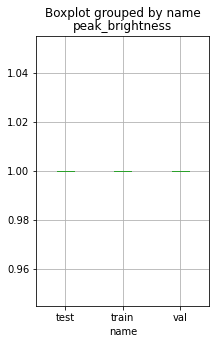

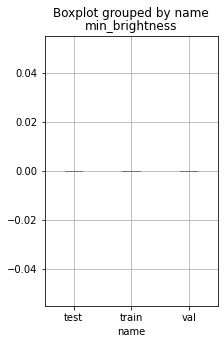

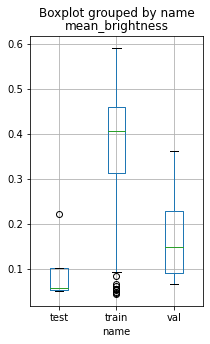

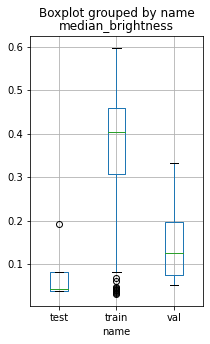

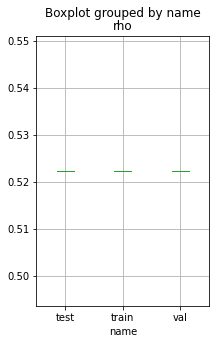

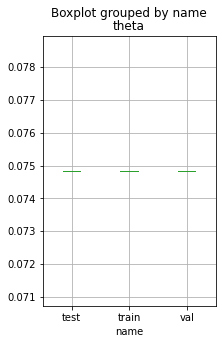

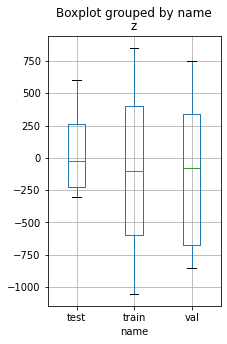

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [3, 5]
def gather_stats(dataset, name, dataset_type='training'):
    records = [] 
    
    if dataset_type == 'training':
        (imgs, coords), z = dataset
    else:
        imgs, coords = dataset
        z = np.zeros((imgs.shape[0]))
    
    for img, coord, z in zip(imgs, coords, z):
        results = {
            'name': name,
            'peak_brightness': img.max(),
            'min_brightness': img.min(),
            'mean_brightness': img.mean(),
            'median_brightness': np.median(img),
            'rho': coord[0],
            'theta': coord[1],
            'z': z,
        }
        records.append(results)
        
    return pd.DataFrame.from_records(records)

if 'all' not in train_dataset.data:
    train = train_dataset.data['train']
    val = train_dataset.data['val']
    test = train_dataset.data['test']

    
    records = []
    records.append(gather_stats(train, 'train'))
    records.append(gather_stats(val, 'val'))
    records.append(gather_stats(test, 'test'))

    
    df = pd.concat(records)
    for col in list(df):
        if col != 'name':
            df.boxplot(by='name', column=col)

(837,)
Rows 84 Cols 10 n_spaces 840 n_psfs 837


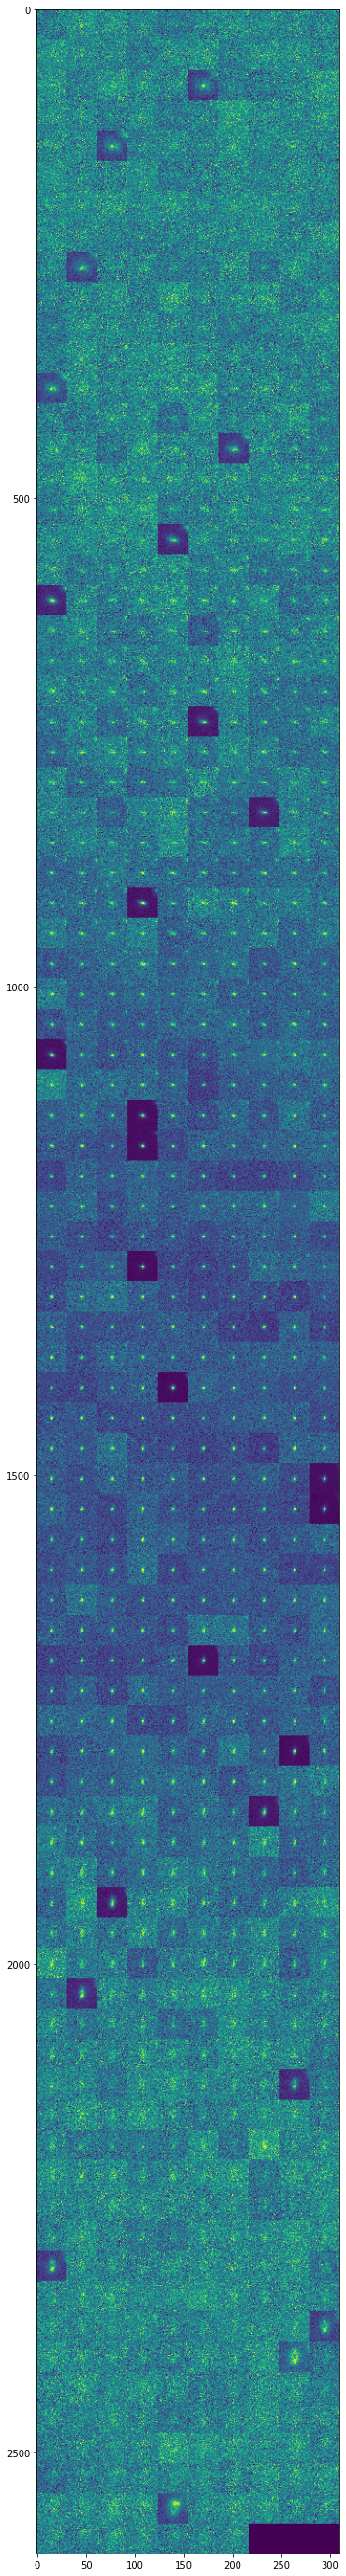

In [5]:
# Inspect training dataset
from data.visualise import grid_psfs
import numpy as np
plt.rcParams['figure.figsize'] = [50, 50]

samples = min(1000, train_dataset.data['train'][1].shape[0])
sub_idx = np.random.choice(np.arange(0, train_dataset.data['train'][1].shape[0]), samples, replace=False)
print(sub_idx.shape)
sub_zs = train_dataset.data['train'][1][sub_idx]
sub_imgs = train_dataset.data['train'][0][0][sub_idx]
idx = np.argsort(sub_zs)
sub_imgs = sub_imgs[idx]

plt.imshow(grid_psfs(sub_imgs.squeeze()))
plt.show()





# 2. Training the model


In [6]:
TRAIN_NEW_MODEL = True

In [7]:
from skimage.transform import resize
import tensorflow as tf
for k in train_dataset.data.keys():
    print(k, train_dataset.data[k][0][0].shape)
    train_dataset.data[k][0][0] = tf.image.grayscale_to_rgb(tf.convert_to_tensor(train_dataset.data[k][0][0])).numpy()
    n_channels = train_dataset.data[k][0][0].shape[-1]
    train_dataset.data[k][0][0] = np.stack([resize(img, (32, 32, n_channels), anti_aliasing=True) for img in train_dataset.data[k][0][0]])
    print(k, train_dataset.data[k][0][0].shape)

train (837, 31, 31, 1)
train (837, 32, 32, 3)
val (8, 31, 31, 1)
val (8, 32, 32, 3)
test (4, 31, 31, 1)
test (4, 32, 32, 3)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 resnet101v2 (Functional)       (None, 2048)         42626560    ['sequential[0][0]']             
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
      

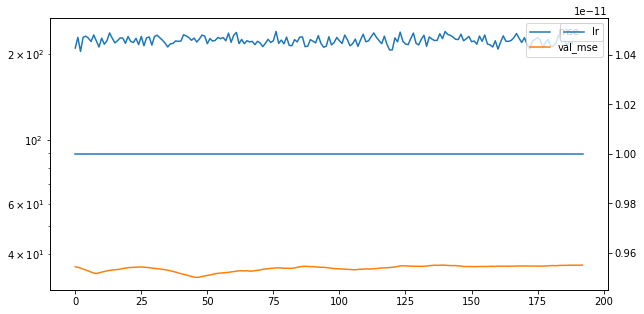

In [14]:
%load_ext autoreload
%autoreload 2

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from model.model import get_resnet_101, save_model, train_model, load_trained_model, compile_model, resnet_model

from wandb.keras import WandbCallback
import numpy as np
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

import wandb
import os
import logging

wandb.login()

bound = train_dataset.data['train'][0][0].shape[1]
n_channels = train_dataset.data['train'][0][0].shape[-1]
LEARNING_RATE = 1e-11

if TRAIN_NEW_MODEL:
#     model = resnet_model(bound)
#     model = get_resnet_101(bound, n_channels, LEARNING_RATE)
    model = load_trained_model('picasso_test_rgb')
#     model.layers[1].trainable = False
    compile_model(model, LEARNING_RATE)
    model = train_model(model, train_dataset.data)
#     save_model(model, dataset+('_rgb' if n_channels == 3 else ''))
else:
    model = load_trained_model(dataset+('_rgb' if n_channels == 3 else ''))


In [9]:
# save_model(model, dataset+('_rgb' if n_channels == 3 else ''))

train


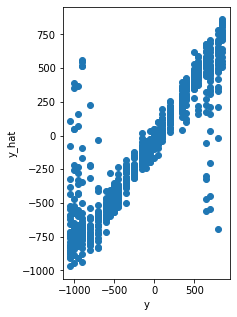

Mean error 146.56741230519157
std error 219.3764461529005


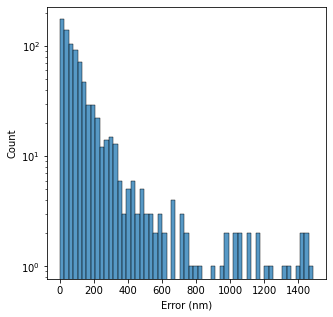

val


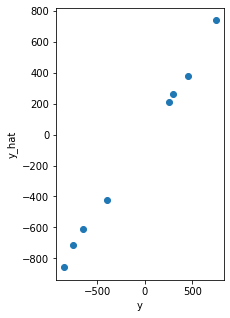

Mean error 33.7353515625
std error 19.136215778470852


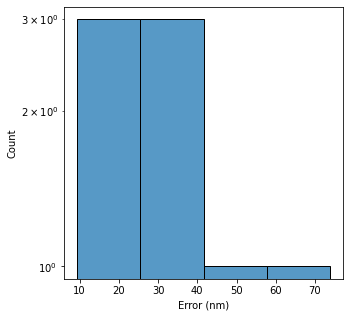

test


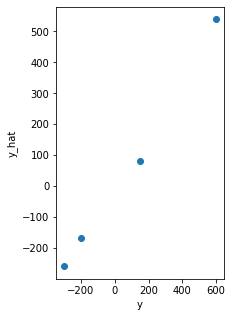

Mean error 50.137088775634766
std error 15.13220887386354


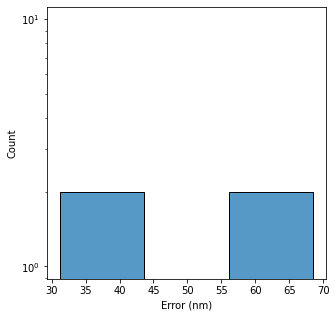

Rows 1 Cols 10 n_spaces 10 n_psfs 4


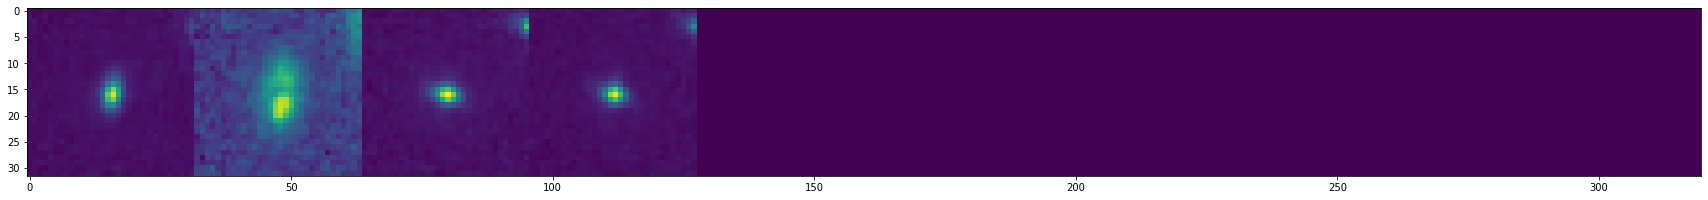

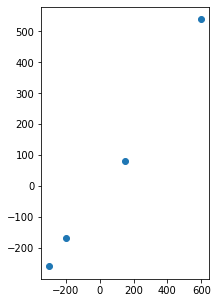

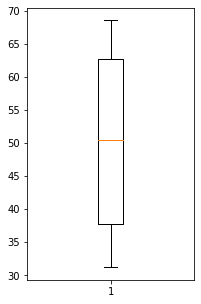

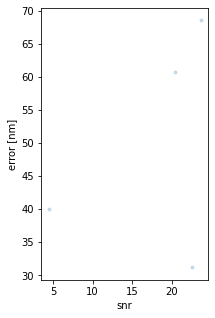

In [10]:
import seaborn as sns
import random

for k in ('train', 'val', 'test'):
    print(k)
    test_x, test_y = train_dataset.data[k]
    pred_y = model.predict(test_x).squeeze()
    error = abs(test_y-pred_y)

    plt.rcParams['figure.figsize'] = [3, 5]
    plt.xlabel('y')
    plt.ylabel('y_hat')

    plt.scatter(test_y, pred_y)
    plt.show()

    
    print(f'Mean error {np.mean(error)}')
    print(f'std error {np.std(error)}')


    plt.rcParams['figure.figsize'] = [5, 5]
    sns.histplot(error)
    plt.yscale('log')
    plt.xlabel('Error (nm)')
    plt.show()

test_x, test_y = train_dataset.data['test']
pred_y = model.predict(test_x).squeeze()
error = abs(test_y-pred_y)
idx = np.argsort(error)[::-1][0:1000]
test_imgs = test_x[0].squeeze()[idx]
plt.rcParams['figure.figsize'] = [30, 50]




def get_imgs_at_depth(depth):
    ids = np.argwhere(abs(train_dataset.data['train'][1]-depth)<5).squeeze()
    imgs = train_dataset.data['train'][0][0][ids]
    if imgs.shape[-1] != 1:
        imgs = imgs.mean(axis=-1)
    imgs = imgs[np.argsort(np.mean(imgs, axis=(1,2)))][0:10]
    return imgs

if test_imgs.shape[-1] !=1:
    test_imgs = test_imgs.mean(axis=-1)
plt.imshow(grid_psfs(test_imgs))
plt.show()


def snr(img):
    return img.max() / np.median(img)

plt.rcParams['figure.figsize'] = [3, 5]
plt.scatter(test_y, pred_y)
plt.show()
error = abs(pred_y-test_y)
plt.boxplot(error)
plt.show()

plt.scatter([snr(img) for img in test_imgs], error, marker='.', alpha=0.2)
plt.xlabel('snr')
plt.ylabel('error [nm]')
plt.show()

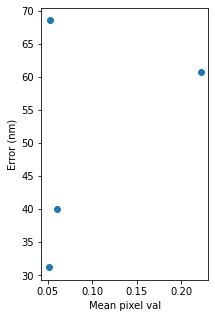

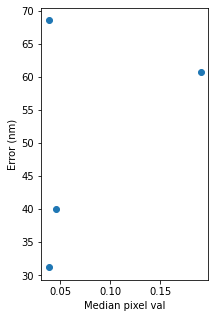

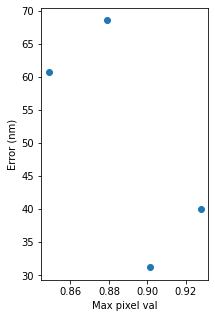

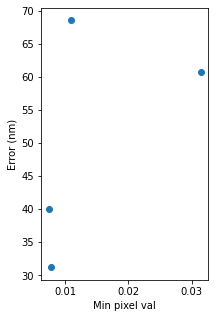

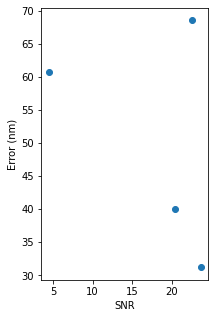

In [11]:
mean_pixel_val = np.mean(test_x[0], axis=(1,2,3))
plt.scatter(mean_pixel_val, error)
plt.xlabel('Mean pixel val')
plt.ylabel('Error (nm)')
plt.show()

median_pixel_val = np.median(test_x[0], axis=(1,2,3))
plt.scatter(median_pixel_val, error)
plt.xlabel('Median pixel val')
plt.ylabel('Error (nm)')
plt.show()

max_pixel_val = np.max(test_x[0], axis=(1,2,3))
plt.scatter(max_pixel_val, error)
plt.xlabel('Max pixel val')
plt.ylabel('Error (nm)')
plt.show()

min_pixel_val = np.min(test_x[0], axis=(1,2,3))
plt.scatter(min_pixel_val, error)
plt.xlabel('Min pixel val')
plt.ylabel('Error (nm)')
plt.show()

snr = [np.max(img) / np.median(img) for img in test_x[0]]
plt.scatter(snr, error)
plt.xlabel('SNR')
plt.ylabel('Error (nm)')
plt.show()